In [1]:
import matplotlib.pyplot as plt
from ctypes import *
from typing import List
from skimage import io
import numpy as np
import xir
import vart
import vitis_ai_library
import os
import math
#import threading
import time
import sys
import queue
#from hashlib import md5
import argparse

from torchvision import transforms as T
from torchvision.transforms import functional as F

In [2]:
images_dir = "./images_folder/images"
model_name = "./build_test/comp_model/UNet2D_compiled.xmodel"



DEBUG = True #False #True
PRINT_IMAGES = False #True

BUF_SIZE = 10
imgQ = queue.Queue(BUF_SIZE)
outQ = queue.Queue(BUF_SIZE)

In [3]:
def correct_dims(*images):
    corr_images = []
    for img in images:
        if len(img.shape) == 2:
            corr_images.append(np.expand_dimgs(img, axis=2))
        else:
            corr_images.append(img)
    if len(corr_images) == 1:
        return corr_images[0]
    else:
        return corr_images

In [4]:
def preprocess_fn(image_path):
    '''
    Image pre-processing.
    Opens image as grayscale then normalizes to range 0:1
    input arg: path of image file
    return: numpy array
    '''
    image = io.imread(image_path)
    print(image.shape)
    image = correct_dims(image)
    image = F.to_pil_image(image)
    #random crop
    i, j, h, w = T.RandomCrop.get_params(image, (256, 256))
    image = F.crop(image, i, j, h, w)
    #image = T.ColorJitter(*(0.1, 0.1, 0.1, 0.1))(image)
    data = np.asarray(image, dtype=np.float32) / 255 #maybe only divide by 128 as the scaling is in signed integer, probably it is also necessary to substract by 1 after that
    return data

In [ ]:
if DEBUG:
        dbg_img = []
        path = "./images_folder/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png"
        dbg_img.append(preprocess_fn(path))
        imgQ.put(dbg_img[0])

In [ ]:
images_list=os.listdir(images_dir)
runTotal = len(images_list)
print('Found',len(images_list),'images - processing',runTotal,'of them')
''' global list that all threads can write results to '''
global out_q
out_q = [None] * runTotal
''' get a list of subgraphs from the compiled model file '''
g = xir.Graph.deserialize(model_name)
subgraphs = g.get_root_subgraph().toposort_child_subgraph()
    
#if DEBUG:
#    subgraph_number = 0
#    for graph in subgraphs:
#        print("subgraph " + str(subgraph_number) + " " +  graph.get_name())
#        subgraph_number += 1
                
runner = vitis_ai_library.GraphRunner.create_graph_runner(g)
    


# get a list of runner inputs
inputTensors = runner.get_input_tensors()
 
# optional – print names and shapes of each input tensor
for inputTensor in inputTensors:
    print('Input tensor :',inputTensor.name, inputTensor.dims)
    
image = imgQ.get()
print("shape of image: " + str(image.shape))


inputData = []
for inputTensor in inputTensors:
    inputData.append(image.reshape(inputTensor.dims))

output_tensor_buffers = runner.get_outputs()
job_id = runner.execute_async(inputData, output_tensor_buffers)
runner.wait(job_id)

In [ ]:
#plot second channel from mask
%matplotlib widget
mask = np.array(output_tensor_buffers[0])
#mask[mask > 0.1] = 1
mask_fig = plt.figure()
plt.imshow(mask[0,:,:,0])

(1024, 1024, 4)


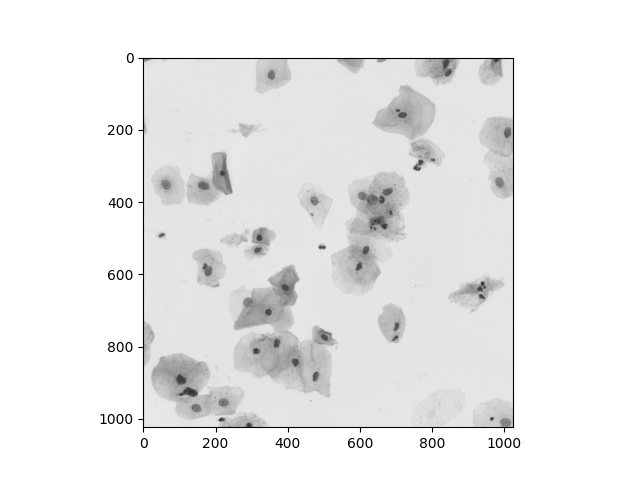

In [8]:
#plot reference mask
%matplotlib widget
#ref_mask = io.imread("./images_folder/masks/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png")
ref_mask = io.imread("./images_folder/images/8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa.png")
print(ref_mask.shape)
mask_ref_fig = plt.figure()
plt.imshow(ref_mask)

In [ ]:
#perpare save as RGB with B being a black channel
mask = np.array(output_tensor_buffers[0])
mask = np.squeeze(mask)
H, W, C = mask.shape
mask = np.append(mask, np.zeros((H, W, 1)), axis=-1)

In [ ]:
#prepare save first channel
mask = np.array(output_tensor_buffers[0])
mask = np.squeeze(mask)
mask = mask[:,:,0]

In [ ]:
#prepare save second channel
mask = np.array(output_tensor_buffers[0])
mask = np.squeeze(mask)
mask = mask[:,:,1]

In [ ]:
#save mask as png
mask = mask * 255
mask = mask.astype(np.uint8)
io.imsave("test.png", mask)